# Implementation for: [An Analysis of Single-Layer Networks in Unsupervised Feature Learning](http://proceedings.mlr.press/v15/coates11a/coates11a.pdf)
Coates A, Ng A, Lee H. An analysis of single-layer networks in unsupervised feature learning[C]//Proceedings of the fourteenth international conference on artificial intelligence and statistics. 2011: 215-223.

## Paper flow
- 3 Unsupervised feature learning framework
    - 3.1 Feature Learning
        - 3.1.1 Pre-processing
        - 3.1.2 Unsupervised learning（KMeans）
    - 3.2 Feature Extraction and Classification
        - 3.2.1 Convolutional extraction
        - 3.2.2 Classification
- 4 Experiments and Analysis
    - 4.1 Visualization
    - 4.2 Effect of whitening
    - 4.3 Number of features
    - 4.4 Effect of stride
    - 4.5 Effect of receptive field size
    - 4.6 Final classification results
- 5 Conclusion

## Method used in the paper
### 3.1 Feature Learning

1. The system begins by extracting **random sub-patches** from unlabeled input images. Each patch has dimension $w$-by-$w$ and has $d$ channels, with $w$ referred to as the “receptive field size”. Each $w$-by-$w$ patch can be represented as a vector in $R^N$ of pixel intensity values, with $N = w · w · d$. 
2. In pre-processing, it use **normalization** function by subtracting the mean and dividing by the standard deviation of every patch $x^{(i)}$ elements. 
3. In pre-processing, after normalizing each input vector, the entire dataset X may optionally be **whitened**. In this paper, the writer did a comparative experiment on **whether to use the whitening method**.
4. In Unsupervised learning, the paper's writer also did a comparative experiment on **using hard KMeans or soft（triangle）KMeans**.

### 3.2 Feature Extraction and Classification

1. I think the new model that paper propose is **nothing more than replacing the convolution operation in the image convolution operation with the kmeans clustering algorithm**. It use this function (unsupervised kmeans clustering algorithm) to extract deeper features of the image, thereby improving the accuracy of supervised classification algorithms.
2. **Change the convolution operation to KMeans clustering**，specifically, given an image of $n$-by-$n$ pixels (with $d$ channels), we define a $((n − w)/s + 1)$-by-$((n − w)/s + 1)$ representation (with $K$ channels), by computing the representation y for each $w$-by-$w$ “subpatch” of the input image. More formally, we will let $y^{(ij)}$ be the K-dimensional representation extracted from location $i; j$ of the input image. For computational efficiency, we may also “step” our $w$-by-$w$ feature extractor across the image with some step-size (or “stride”) s greater than 1. ($K$: Kmeans's num of centroids; $w * w$: patch-size; $s$: convolution operation step; $d$: image's depth)
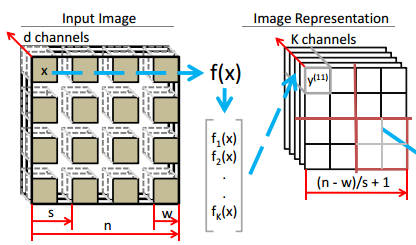
3. Before classification, it is standard practice to reduce the dimensionality of the image representation by **pooling**, beacuse there is too many representation produced after the convolution operation. In this paper, they split the $y^{(ij)}$’s into four equal-sized quadrants, and compute the sum of the $y^{(ij)}$’s in each. Finally, you can get 4K features that you use for classification after pooling operation.
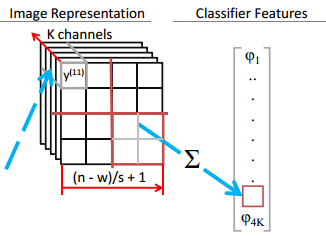
4. Given these pooled (4K-dimensional) feature vectors for each training image and a label, we apply standard linear classification algorithms. In this paper, they use **(L2) SVM classification**. The regularization parameter is determined by cross-calidation.


## Implementation for this paper

In [ ]:
#Document header file
import math
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets, model_selection
from sklearn.metrics import classification_report
from collections import Counter

### 3 Unsupervised feature learning framework

#### 3.1 Feature Learning

##### Load Minst dataset
In there, I use [OpenML MINST dataset](https://www.openml.org/d/554). You can easily use it by using [sklearn fetch_openml function](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_openml.html) to fetch the dataset you what from openml by name or dataset id.

In [2]:
#Import datasets via sklearn and observe the size of the dataset
mnist = datasets.fetch_openml('mnist_784')
data, target = mnist.data, mnist.target
data.shape, target.shape

((70000, 784), (70000,))

In [3]:
#Since we need to use the convolution method to continue the operation, 
#we first convert the image from 1 dimension to 2 dimensions (28*28).
feature = data.reshape((data.shape[0], 28, 28))
feature.shape

(70000, 28, 28)

feature sample(0) with target is 5 :
 [[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   3.  18.
   18.  18. 126. 136. 175.  26. 166. 255. 247. 127.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.  30.  36.  94. 154. 170. 253.
  253. 253. 253. 253

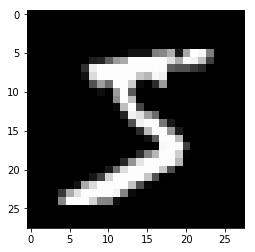

In [4]:
#Observe data sample (Pixel features)
plt.gray()
print("feature sample(0) with target is %s :\n" % target[0], feature[0])
plt.imshow(feature[0])

In [5]:
#Observe the pixel distribution in image
print("min: ", min(feature[0].ravel()))
print("max: ", max(feature[0].ravel()))
print("mean: ", np.mean(feature[0].ravel()))
print("feature.dtype: ", feature.dtype)
print("target.dtype: ", target.dtype)

min:  0.0
max:  255.0
mean:  35.108418367346935
feature.dtype:  float64
target.dtype:  object


(70000, 256)


<BarContainer object of 256 artists>

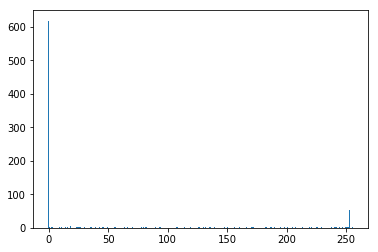

In [6]:
#Draw a color histogram for observation
def mk_gray_np(datas):
    gray_np = np.zeros([datas.shape[0], 256])
    for index, data_line in enumerate(datas):
        for i in data_line:
            gray_np[index][int(i)] += 1
    return gray_np

gray_np = mk_gray_np(data)
print(gray_np.shape)

plt.bar(range(len(gray_np[0])), gray_np[0])

By observing the color histogram of the MINST raw image, we can see that most of its colors are concentrated on the values 0 and 255. In fact, we can also binarize it to reduce the computational complexity. This will be discussed later.

##### Random sub-patches
The system begins by extracting **random sub-patches** from unlabeled input images. Each patch has dimension $w$-by-$w$ and has $d$ channels, with $w$ referred to as the “receptive field size”. Each $w$-by-$w$ patch can be represented as a vector in $R^N$ of pixel intensity values, with $N = w · w · d$. 


Randomly select several sub-patches from each image to train our K-means model. Here I use to set the total number of sub_patches for all samples, and then traverse all the data sets in turn, each time traversing only select a sub-slice from the traversing image.

In [7]:
#global variable define
g_w = 6                         #Receptive field size (pixels)
g_s = 1                         #Stride between extracted features (pixels)
g_d = 1                         #Image depth
g_K = 1600                      #Kmeans's num of centroids (num of features)
g_whitening = True              #using whitening or not (using raw data)

patches_num = 500000             #images num, each image contain many (choose from the random start position) sub-patches

In [10]:
def get_subpatches(X_train):
    #patches array: Store all images' sub-patches
    patches=[]
    #iterate patches_num image, to get every image's random sub-patches
    for i in range(patches_num):
        #so random initialize the start patch's position
        #Attention: 
        #the last patch's rightmost pixel cannot exceed the right border of the image
        #the last patch's bottom pixel cannot exceed the bottom border of the image 
        start_row = np.random.randint(28 - g_w)
        start_col = np.random.randint(28 - g_w)

        #initialize patch array: Store image's sub-patches
        patch = np.array([])

        #choose a image according to the order, so we can choose sub-patches from it
        image = X_train[np.mod(i, X_train.shape[0])]        
        #For each image, start choose each w*w size sub-patches from the start position.
        #Becasuse the image depth of MINST dataset is 1, so we can code like follow, 
        #eliminates the hassle of operating on different image depth layers.
        patch = image[start_row : start_row + g_w].T[start_col : start_col + g_w].T.ravel()
        
        #add this sub-patches to patches
        patches.append(patch)
    
    #use numpy array to store patches array
    patches = np.array(patches)
    
    #return patches array
    return patches

In [11]:
patches = get_subpatches(feature)
print("patches array shape: ", patches.shape)
print("sub-patch sample(0) is:\n", patches[0])
patches.max()

patches array shape:  (500000, 36)
sub-patch sample(0) is:
 [  1.   0.   0.   0.   0.   0. 119.  25.   0.   0.   0.   0. 253. 150.
  27.   0.   0.   0. 252. 253. 187.   0.   0.   0. 249. 253. 249.  64.
   0.   0. 253. 253. 207.   2.   0.   0.]


255.0

##### Normalization
In pre-processing, it use **normalization** function by subtracting the mean and dividing by the standard deviation of every patch $x^{(i)}$ elements. 

Tips: Standard deviation is the square root of the variance, which represents the average dispersion of a set of data about the mean.

In [12]:
def normalize_patches(patches):
    #In there we change the standard deviation to the square root of the variance add a number 10,
    #beacuse, we will get INF if not. 
    #And you cannot eigenvalue decomposition of the covariance matrix with INF contained in the array.
    #If you don't believe, you can try, use the traditional standard deviation algorithm and do the whiten.
    return (patches - patches.mean(1)[:, None]) / np.sqrt(patches.var(1)+10)[:, None]

In [13]:
norm_patches = normalize_patches(patches)
print("Normalization patches array shape: ", norm_patches.shape)
print("Normalization sub-patch sample(0) is:\n", norm_patches[0])

Normalization patches array shape:  (500000, 36)
Normalization sub-patch sample(0) is:
 [-0.71819236 -0.7275567  -0.7275567  -0.7275567  -0.7275567  -0.7275567
  0.386799   -0.49344836 -0.7275567  -0.7275567  -0.7275567  -0.7275567
  1.6416197   0.67709334 -0.47471969 -0.7275567  -0.7275567  -0.7275567
  1.63225537  1.6416197   1.02357368 -0.7275567  -0.7275567  -0.7275567
  1.60416237  1.6416197   1.60416237 -0.12823935 -0.7275567  -0.7275567
  1.6416197   1.6416197   1.21086036 -0.70882803 -0.7275567  -0.7275567 ]


##### Whitening
In pre-processing, after normalizing each input vector, the entire dataset X may optionally be **whitened**. In this paper, the writer did a comparative experiment on **whether to use the whitening method**.

There have some tips about how to whiten matrix in PCA: [How to whiten matrix in PCA | Stack Overflow
](https://stackoverflow.com/questions/6574782/how-to-whiten-matrix-in-pca)

In [14]:
def whiten(train_X, fudge=1E-18):    
    #get the covariance matrix
    x_cov = np.cov(train_X, rowvar=0)
    #eigenvalue decomposition of the covariance matrix
    d, V = np.linalg.eig(x_cov)
    #a fudge factor can be used so that eigenvectors associated with
    #small eigenvalues do not get overamplified.
    D = np.diag(np.sqrt(1 / (d + 0.1)))
    #whitening matrix
    W = np.dot(np.dot(V, D), V.T)
    #multiply by the whitening matrix
    X_white = np.dot(train_X, W)
    
    return X_white, W

In [16]:
whiten_norm_patches, whiten_martrix = whiten(norm_patches)
print("Whitened normalization patches array shape: ", whiten_norm_patches.shape)
print("Whitened normalization sub-patch sample(0) is:\n", whiten_norm_patches[0])

Whitened normalization patches array shape:  (500000, 36)
Whitened normalization sub-patch sample(0) is:
 [-0.69643132 -0.58896335 -0.31617601 -0.25985834 -0.28018979 -0.25481952
  0.38132577 -0.93578882 -0.62605992 -0.20319589 -0.1674729  -0.2235874
  1.71445928  0.4527028  -1.19825605 -0.55698789 -0.13137596 -0.20597206
  0.63428732  1.29341822  1.18249337 -1.39804611 -0.24520187 -0.21926673
  0.43407373  0.49610673  1.78701028 -0.17943455 -0.3640007  -0.25675135
  0.66481389  0.79775197  1.20578825 -1.27658023 -0.20865881 -0.25115604]


##### KMeans
In Unsupervised learning, the paper's writer also did a comparative experiment on **using hard KMeans or soft（triangle）KMeans**

**Calculate the shortest distance from each patch to k centroids, and its corresponding centroid number (k_idx).**

I use matrix operations to simplify the formula, the calculation process is as follows：

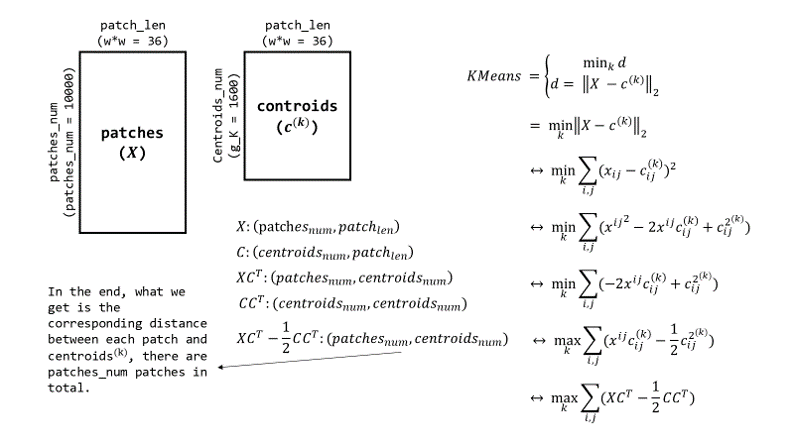

**In order to update our k centroids by iteration, we need to calculate the average of all the patches corresponding to each centroid (one of k) and update it to the centroid.**

I gave the corresponding pseudo code as follows:

```
for k == k_idx:
    mean all the patch(k)
    update the mean to centroid(k)
```

In there, I still use matrix operations to simplify the formula, the calculation process is as follows： 

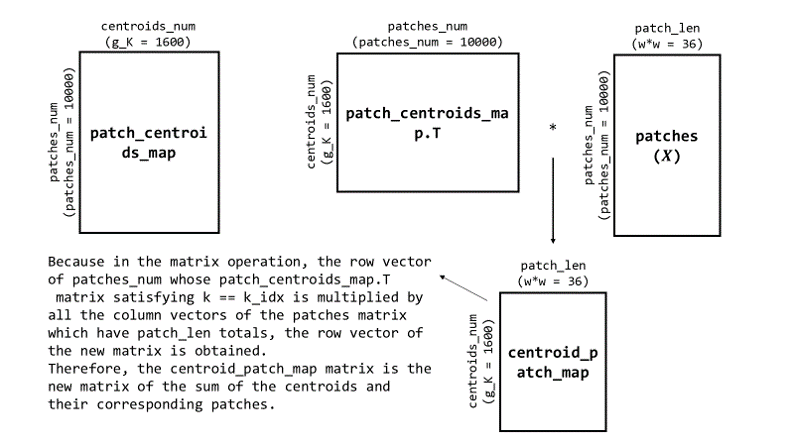

In [39]:
def my_kmeans(patches):
    #random select centroids
    #centroids' number is g_K variable
    #In there, we multiply the random array we get by 0.1 to match 
    #the range of values of whiten_norm_patches as much as possible.
    #You can observe the distribution of the values of the whiten_norm_patches 
    #in the code block above.
    centroids = np.random.randn(g_K, patches.shape[1])*.1
    
#     #There is a mathematical trick when solving the centroid with the smallest Euclidean distance.
#     #I give the formula derivation in the form of a picture above.
#     c2 = 0.5 * np.power(centroids, 2).sum(1)
#     xc = np.dot(patches, centroids.T)
#     k_idx = np.argmax(xc-c2, axis=1)
    
    #the algorithm in the above is state-of-the-art,
    #but, we also need to update our centroids,
    #so, I update the above algorithm as the following.
    
    #number of iteration, updating k centroids
    #here I used the number of iterations to end my training early, 
    #because my computer really can't run to meet the real end situation.
    iteration_num = 100
    #my poor computer made me have to use mini batch,
    #because it doesn't have enough memory,
    #what a hard work it is!
    batch_size = 1000
    for it in range(iteration_num):
        #Calculate the shortest distance from each patch to k centroids, 
        #and its corresponding centroid number (k_idx)          
        c2 = np.power(centroids, 2).sum(1)
        
        centroid_patch_map = np.zeros_like(centroids)
        centroid_patches_num = np.zeros(g_K)
        
        for i in range(0, patches.shape[0], batch_size):
            last_i = min(i+batch_size, patches.shape[0])
            
            xc = np.dot(patches[i:last_i], centroids.T)
            k_idx = np.argmax(xc-c2, axis=1)
        
            #In order to update our k centroids by iteration, 
            #we need to calculate the average of all the patches corresponding  
            #to each centroid (one of k) and update it to the centroid.
            patch_centroids_map = np.zeros([last_i-i, g_K])
            patch_centroids_map[range(last_i-i), k_idx] = 1

            centroid_patch_map += np.dot(patch_centroids_map.T, patches[i:last_i])
            #number of each centroid corresponding to patches
            centroid_patches_num += patch_centroids_map.sum(0)
        
        #update centroids
        centroids = centroid_patch_map / centroid_patches_num[:,None]
        #some centroids don't get any sub_patchesm
        #let them stay zero, or you get something wrong
        centroids[centroid_patches_num==0] = 0     
            
    return k_idx, centroids

In [40]:
k_idx, centroids = my_kmeans(whiten_norm_patches)
print("k_idx shape: ", k_idx.shape)
print("centroids shape: ", centroids.shape)

D:\anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide


k_idx shape:  (1000,)
centroids shape:  (1600, 36)


#### 3.2 Feature Extraction and Classification

##### Change the convolution operation to KMeans clustering
Given an image of $n$-by-$n$ pixels (with $d$ channels), we define a $((n − w)/s + 1)$-by-$((n − w)/s + 1)$ representation (with $K$ channels), by computing the representation y for each $w$-by-$w$ “subpatch” of the input image. More formally, we will let $y^{(ij)}$ be the K-dimensional representation extracted from location $i; j$ of the input image. For computational efficiency, we may also “step” our $w$-by-$w$ feature extractor across the image with some step-size (or “stride”) s greater than 1. ($K$: Kmeans's num of centroids; $w * w$: patch-size; $s$: convolution operation step; $d$: image's depth)
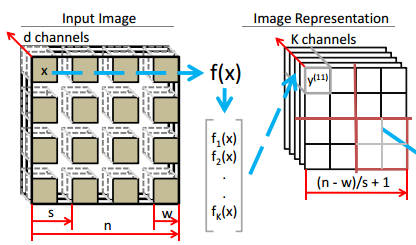

In [57]:
#after change, the output image's (image representation) row and col
g_row = int((28 - g_w)/g_s + 1)
g_col = int((28 - g_w)/g_s + 1)
g_output_size = g_row * g_col

In [61]:
#sampling the input image sequence in steps
def image2patch(image):
    patches = []
    
    start_row = 0
    start_col = 0
    
    for i in range(g_output_size):
        #sample sub-patch
        patch = np.array([])
        patch = image[start_row : start_row + g_w].T[start_col : start_col + g_w].T.ravel()
        patches.append(patch)
        
        #update the next sample sub-patch's col and row
        start_col += 1
        if(start_col == g_col):
            start_col = 0
            start_row += 1
            
    #use numpy array to store patches array
    patches = np.array(patches) 
    
    #return patches array
    return patches

In the paper, the writer use the method of soft (triangle) kmeans to get the feature map $f$. Below is the formula given by the author for soft kmeans.
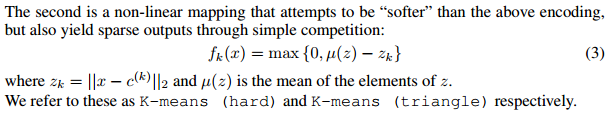

In [62]:
#calculate the distance between each patch to centroids
#use soft (triangle) KMeans
def my_tri_kmeans(patches, centroids):
    x2 = np.power(patches, 2).sum(1)
    c2 = np.power(centroids, 2).sum(1)
    xc = np.dot(patches, centroids.T)

    z = np.sqrt(x2[:,None]-2*xc+c2)
    u = z.mean(1)
    patches = np.maximum(u[:,None]-z, 0)
    
    return patches

In [ ]:
def mk_image_representation(patches):
    
    patches = np.reshape(patches, [g_row, g_col, -1])
    
    return patches

##### Pooling
Before classification, it is standard practice to reduce the dimensionality of the image representation by **pooling**, beacuse there is too many representation produced after the convolution operation. In this paper, they split the $y^{(ij)}$’s into four equal-sized quadrants, and compute the sum of the $y^{(ij)}$’s in each. Finally, you can get 4K features that you use for classification after pooling operation.
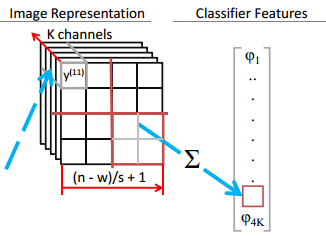

In [68]:
def pooling(patches):
    pool = []
    
    pool.append(patches[0:g_row//2, 0:g_col//2].sum(0).sum(0))
    pool.append(patches[0:g_row//2, g_col//2:g_col].sum(0).sum(0))
    pool.append(patches[g_row//2:g_row, 0:g_col//2].sum(0).sum(0))
    pool.append(patches[g_row//2:g_row, g_col//2:g_col].sum(0).sum(0))
    
    pool = np.array(pool).ravel()
    
    return pool    

##### Feature Extraction

In [64]:
def extract_feature(X_train):
    new_Train = []
    
    for img in X_train:
        
        #image to patches
        patches = image2patch(img)
        #normalize patches
        norm_patches = normalize_patches(patches)
        #whitening
        whiten_norm_patches, whiten_martrix = whiten(norm_patches)
        
        #calc triangle kmeans function f
        new_patches = my_tri_kmeans(whiten_norm_patches, centroids)
        #get new output image (image representation)
        output_patches = mk_image_representation(new_patches)
        #pooling
        image_new_feature = pooling(output_patches)
        
        new_Train.append(image_new_feature)
        
    new_Train = np.array(new_Train)
    norm_new_Train = normalize_patches(new_Train)

    return norm_new_Train  

##### (L2) SVM classification
Given these pooled (4K-dimensional) feature vectors for each training image and a label, we apply standard linear classification algorithms. In this paper, they use **(L2) SVM classification**. The regularization parameter is determined by cross-calidation.

###### Split training and test set samples

In [50]:
#get a random array
indx = np.random.choice(len(target), len(target), replace=False)

#build new data and target arrays of a certain length
def mk_dataset(size, data, target):
    train_X = [data[i] for i in indx[:size]]
    train_X = np.array(train_X)
    train_y = [target[i] for i in indx[:size]]
    train_y = np.array(train_y)
    
    return train_X, train_y

In [53]:
#generate samples and labels for the train set
train_X, train_y = mk_dataset(50000, feature, target)
train_X.shape, train_y.shape

((50000, 28, 28), (50000,))

In [55]:
#generate samples and labels for the test set
def mk_test_dataset(data, target):
    test_X = [data[i] for i in indx[-10000:]]
    test_X = np.array(test_X)
    test_y = [target[i] for i in indx[-10000:]]
    test_y = np.array(test_y)
    
    return test_X, test_y

test_X, test_y = mk_test_dataset(feature, target)
test_X.shape, test_y.shape

((10000, 28, 28), (10000,))

Get the new feature of train feature and test feature after feature extraction

In [ ]:
new_Train = extract_feature(train_X)
new_Test = extract_feature(test_X)

###### L2 SVM (Using sklearn)

This experiment make me crazy and stupid. In order to quickly turn in my homework, I decided to use sklearn directly.

Train SVM Model

In [ ]:
from sklearn.svm import LinearSVC
clf = LinearSVC(penalty="l2", random_state=0)
clf.fit(new_Train, train_y)

Test SVM Model

In [ ]:
pred_y = clf.predict(new_Test)
print(classification_report(test_y, pred_y))

## Experiments and Analysis

### Comparative Experiment

#### Model self-parameter adjustment

##### Image Feature (Whether to binarize)

##### Number of features sampled by kMeans (number of centroids)

##### Whitening or raw

##### Receptive field size (sub-patch size)

##### Stride between extracted features (Sampling Rate)

##### Hard of soft KMeans clustering

#### SVM classification after feature extraction by kmens clustering VS other models

##### Convolutional Neural Networks

##### Deep Boltzmann Machines 

##### Deep Belief Networks 

### Analysis

## Conclusion